In [1]:
from segmentation import *
from utils import *
from optimization import Optimesh

In [2]:
image = plt.imread('../data/test.jpg')
fov = 97

### Subject Mask Segmentation

2/2 [==============================] - 0s 6ms/step


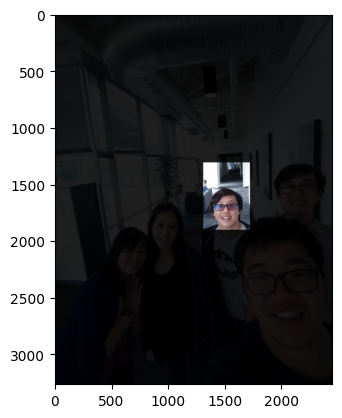

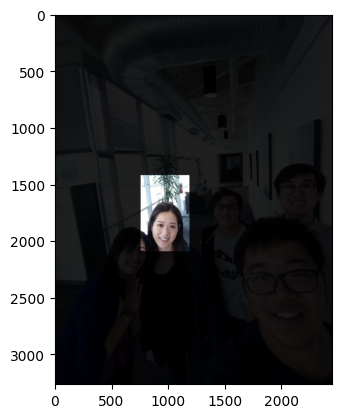

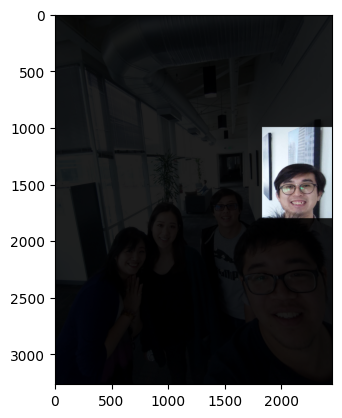

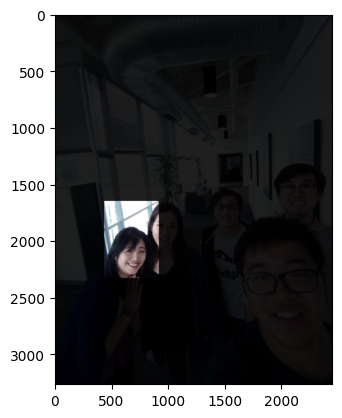

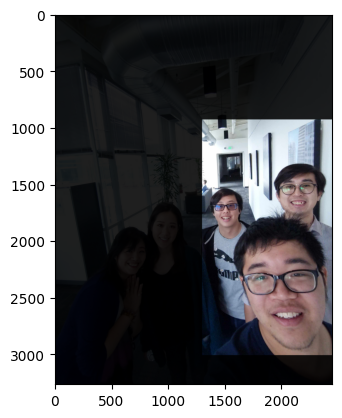

c:\Users\Pengtao Ni\anaconda3\envs\15663\lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Using cache found in C:\Users\Pengtao Ni/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Pengtao Ni\anaconda3\envs\15663\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pengtao Ni\anaconda3\envs\1566

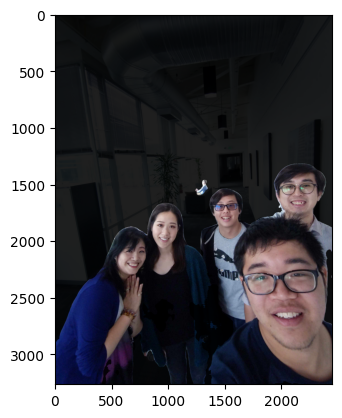

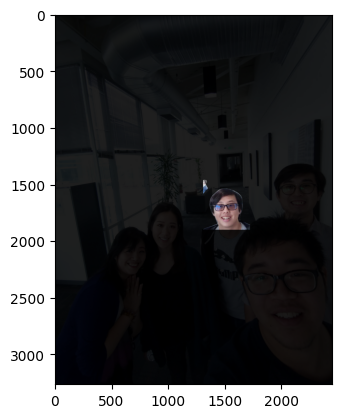

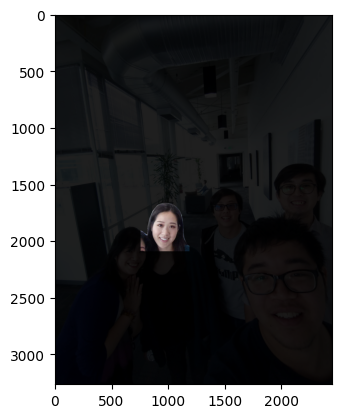

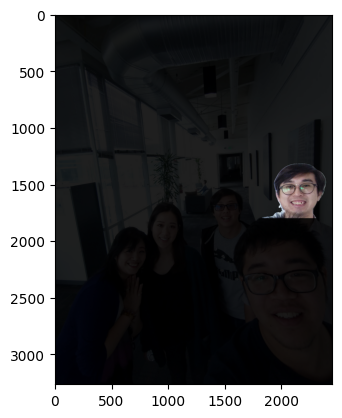

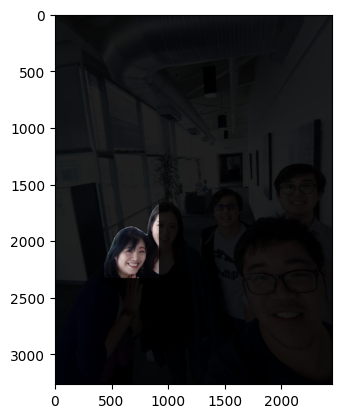

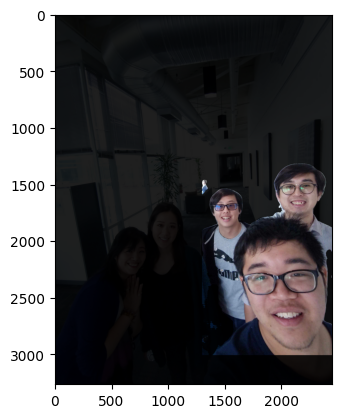

In [3]:
face_masks = get_face_masks(image, debug=True)

In [4]:
face_weights = get_face_weights(face_masks)

### Stereographic Projection

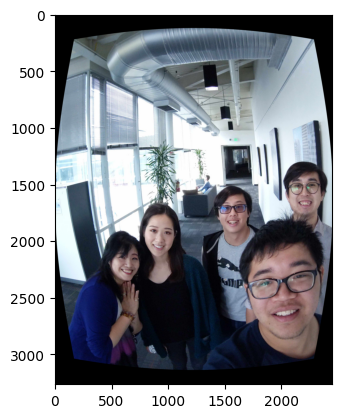

In [5]:
stereo_proj = stereographic_projection(image, fov)

### Mesh

In [6]:
source_mesh, stereographic_mesh = get_meshes(image, fov)

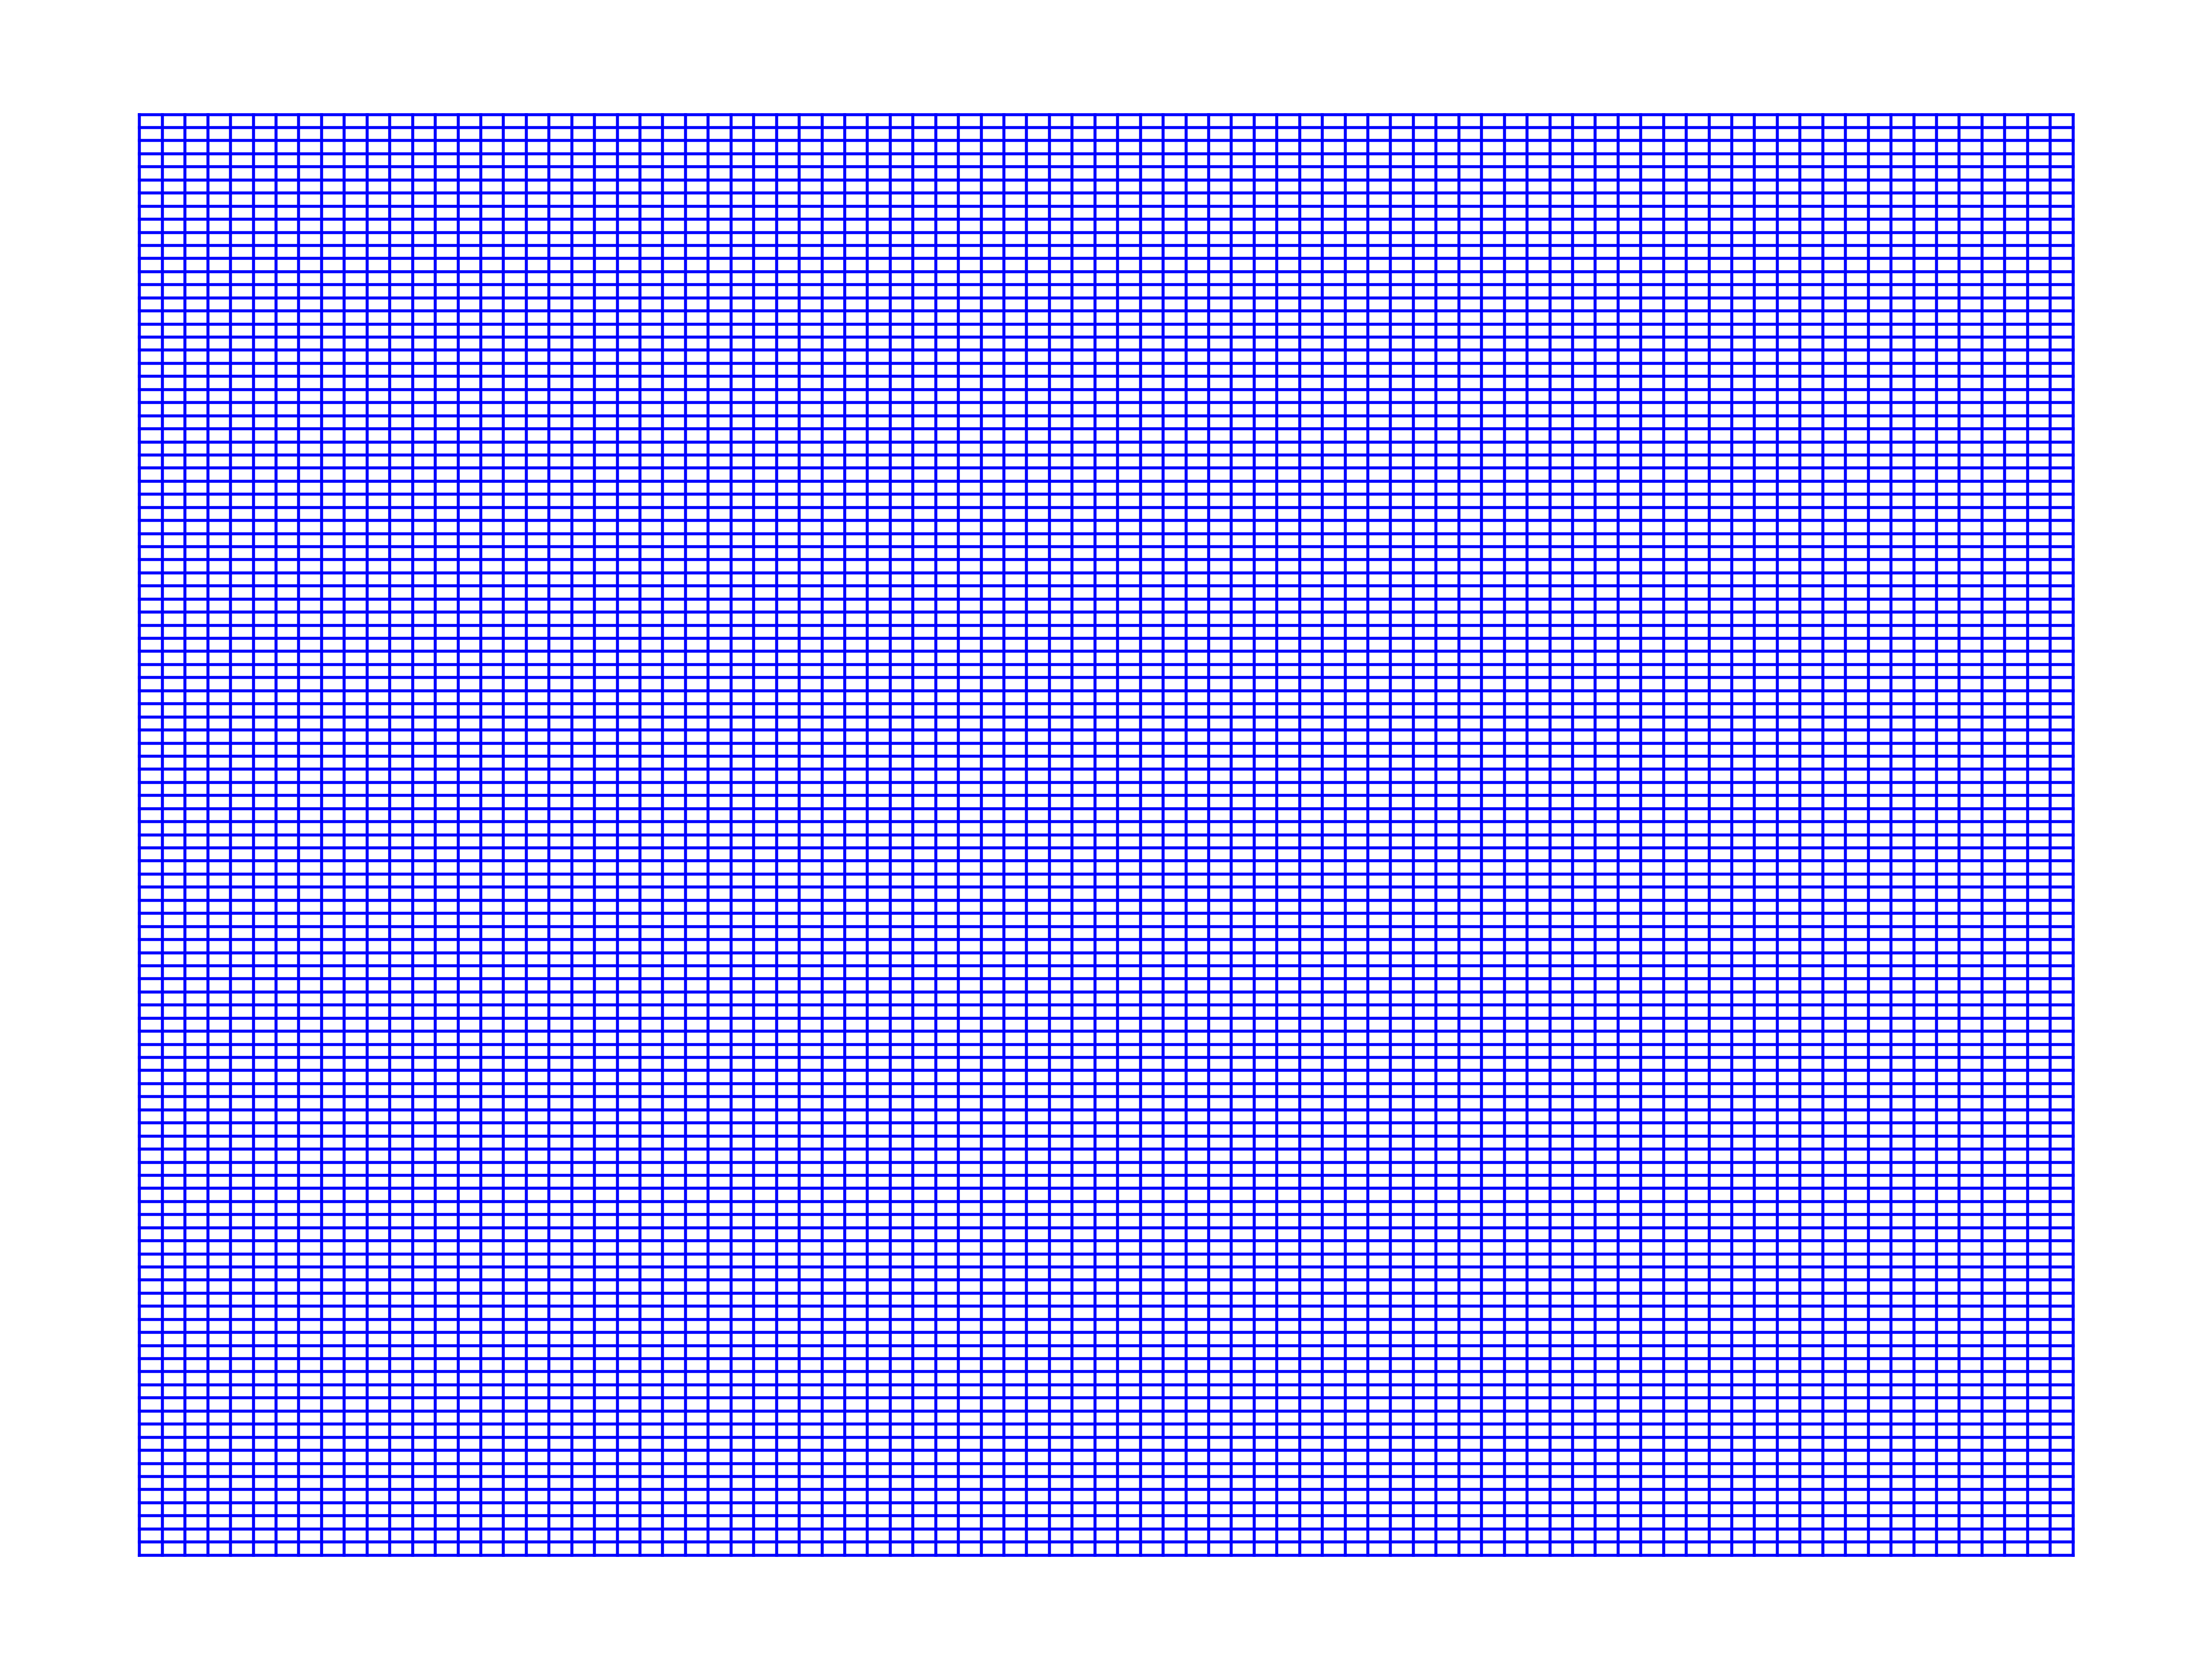

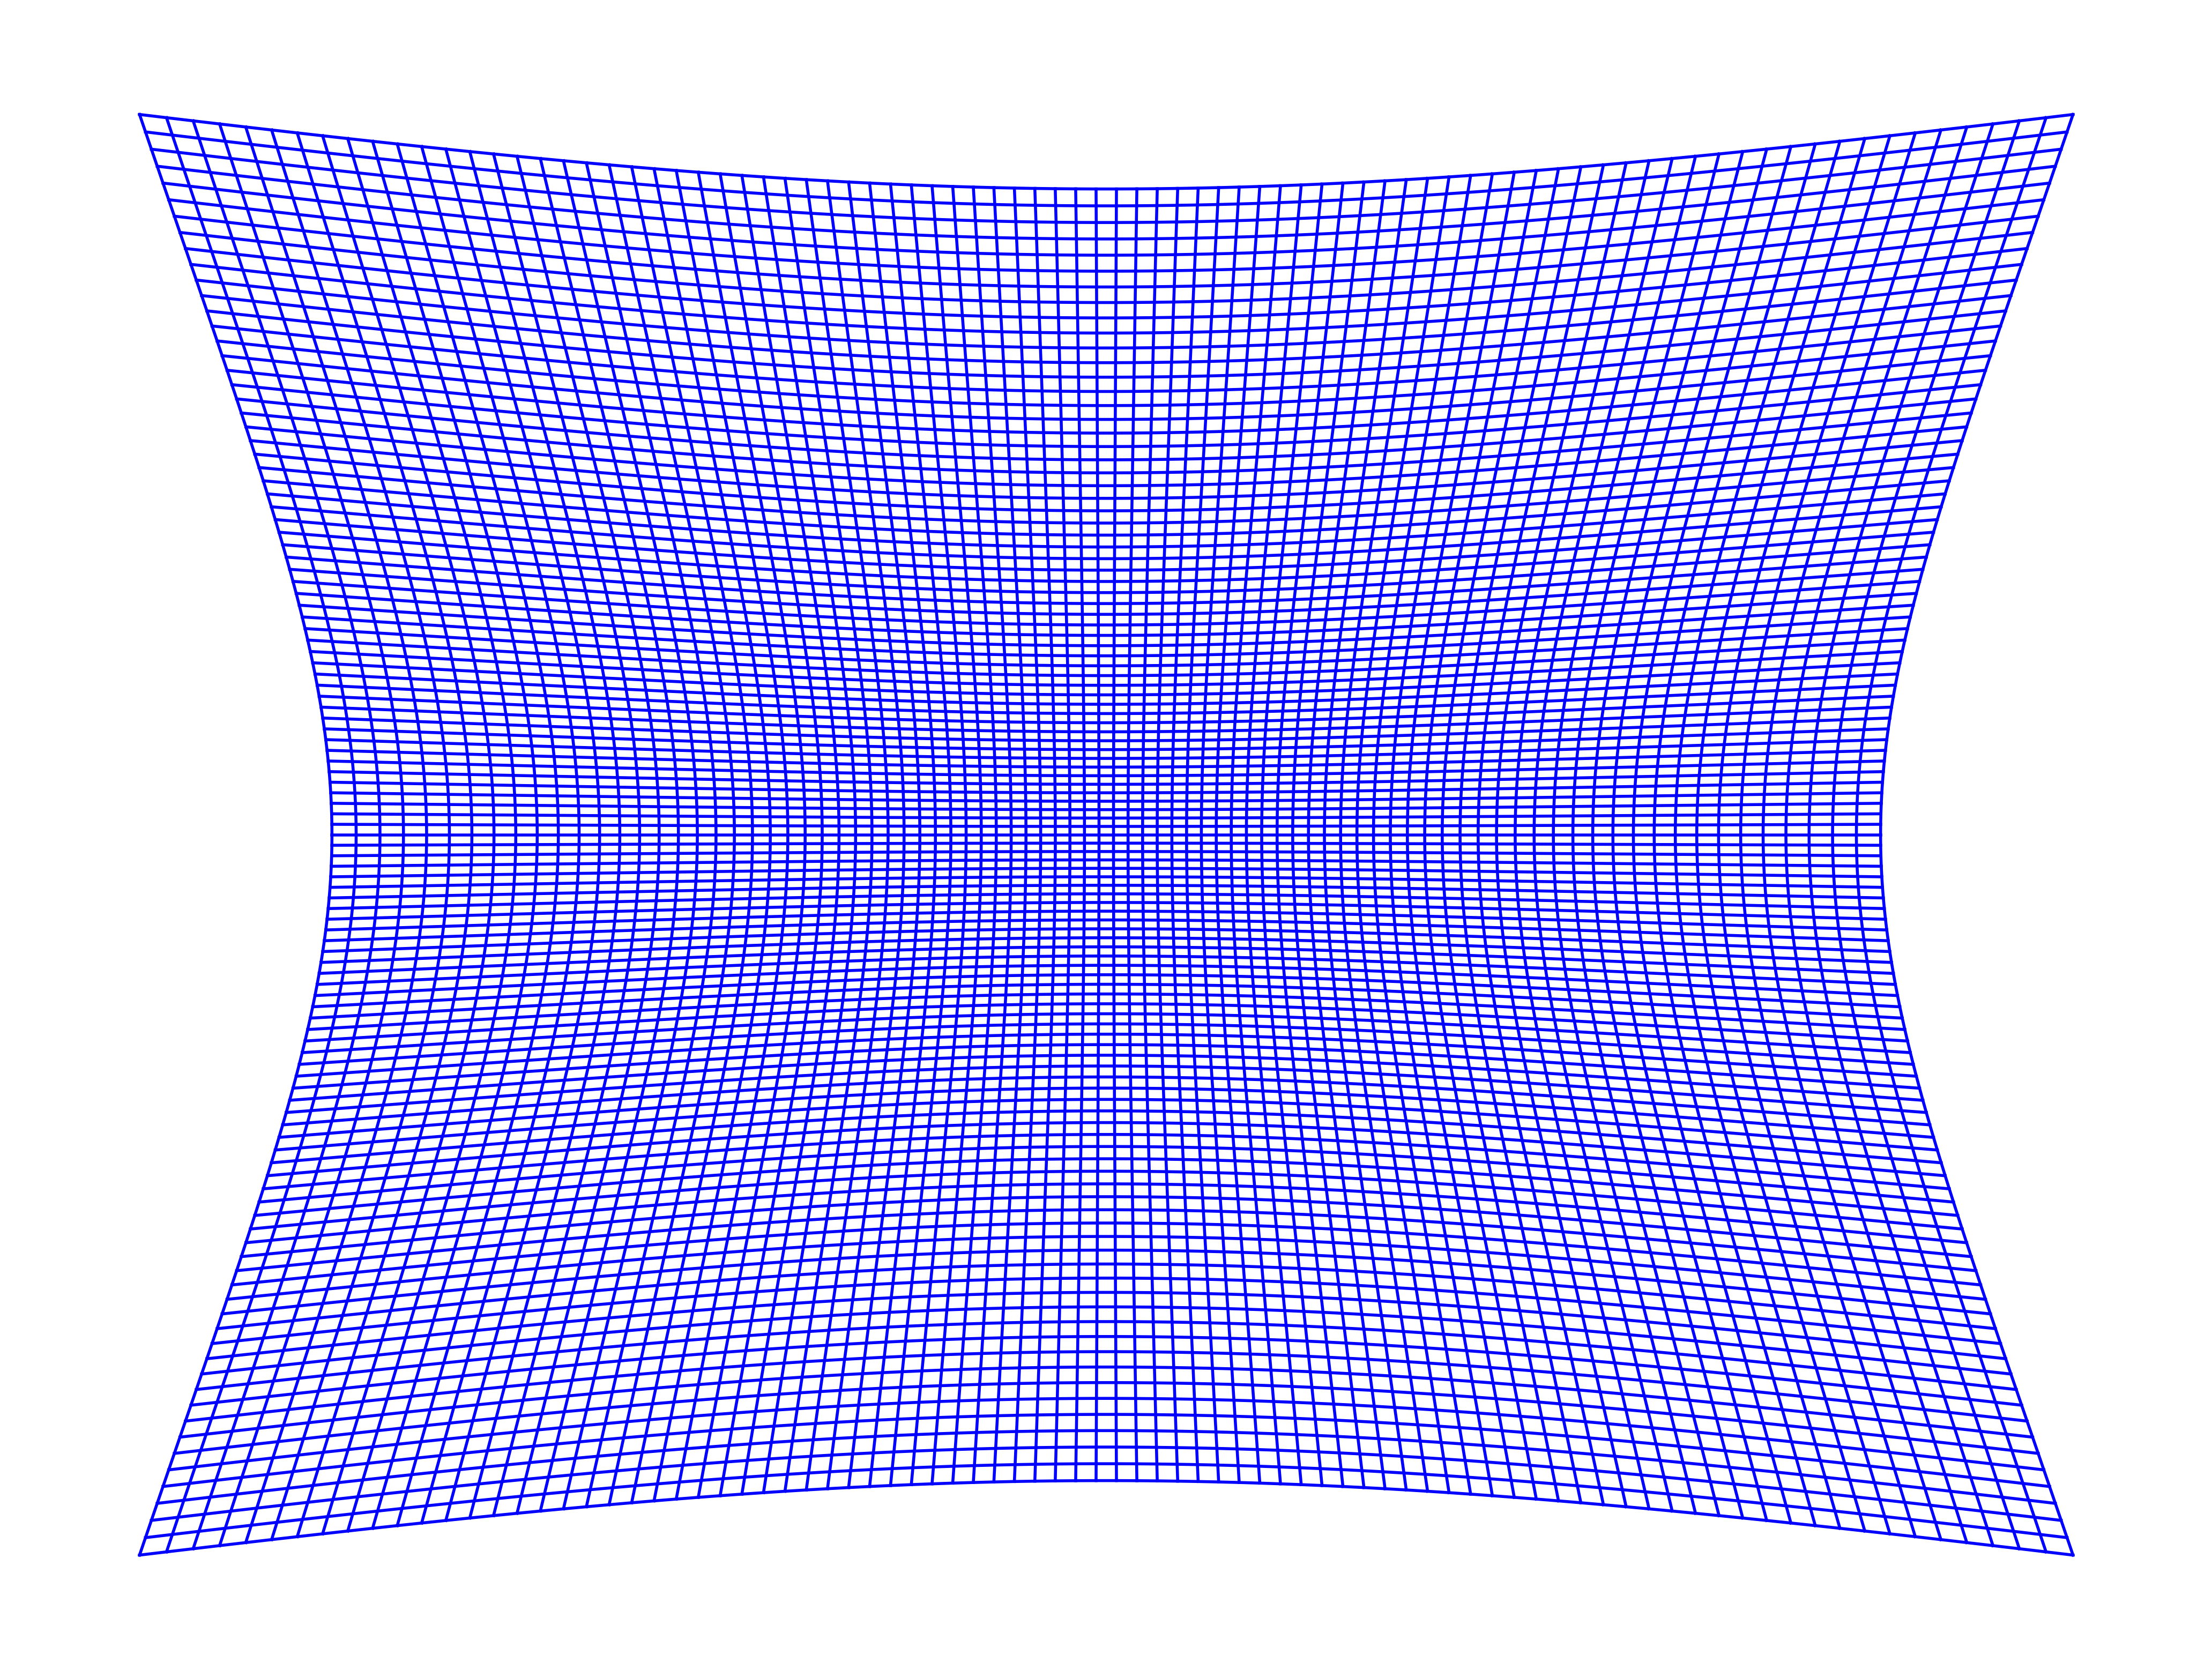

In [7]:
plot_mesh(source_mesh)
plot_mesh(stereographic_mesh)

In [8]:
correction_strength = radial_sigmoid(image, source_mesh, fov)

### Optimization

In [28]:
import torch
import torch.nn as nn

class Optimesh(nn.Module):

    def __init__(self, source_mesh, stereographic_mesh, face_weights,
                 correction_strength, padding=4,
                 lbd_f=4.0, lbd_b=2.0, lbd_r=0.5, lbd_a=4.0):
        super(Optimesh, self).__init__()

        self.source_mesh = torch.tensor(source_mesh, dtype=torch.float32)
        self.stereographic_mesh = torch.tensor(stereographic_mesh, dtype=torch.float32)

        self.face_weights = torch.tensor(face_weights, dtype=torch.float32)
        self.padding = torch.tensor(padding, dtype=torch.float32)
        self.correction_strength = torch.tensor(correction_strength, dtype=torch.float32)

        self.lbd_f, self.lbd_b, self.lbd_r, self.lbd_a = lbd_f, lbd_b, lbd_r, lbd_a

        # trainable parameters
        self.mesh = torch.tensor(source_mesh, dtype=torch.float32)
        self.mesh = nn.Parameter(self.mesh)
        self.transform = torch.tensor([[1.0, 0.0, 0.0, 0.0]]).repeat(3, 1)
        self.transform = nn.Parameter(self.transform)

    def forward(self):
        E_f = self.face_objective_term()

        energy = self.lbd_f * E_f

        return energy

    def face_objective_term(self, ws=2000, st=1):
        padding = self.padding
        Mv = self.mesh[padding:-padding, padding:-padding, :]
        Mu = self.stereographic_mesh[padding:-padding, padding:-padding, :]

        energy = 0
        for k in range(len(self.face_weights)):
            target = torch.tensordot(Sk, Mu, dims=([-1], [-1])).transpose(1,2,0) + tk
            dist = torch.norm(Mv - target, dim=-1)

            ak, bk, tk1, tk2 = self.transform[k]
            Sk = torch.tensor([[ ak, bk],
                               [-bk, ak]])
            tk = torch.tensor([tk1, tk2])
            regularizer = ws * torch.abs(ak - st)

            energy += self.face_weights * self.correction_strength * dist + regularizer
        
        return energy
    
    def line_bending_term():
        pass

    def Regularization_term():
        pass

In [29]:
model = Optimesh(source_mesh, stereographic_mesh, face_weights, correction_strength)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

torch.Size([111, 86, 2])


In [27]:
for i in range(100):
    optimizer.zero_grad()
    loss = model.forward()
    loss.backward()
    optimizer.step()
    print(loss.item())

forward
face_objective_term


AttributeError: 'Optimesh' object has no attribute 'shape'